In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import export_graphviz
from scipy.stats import chi2_contingency
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, auc
from sklearn.preprocessing import label_binarize

In [ ]:
cnx = sqlite3.connect('database.sqlite')

player_data = pd.read_sql("SELECT id, player_api_id, player_name, birthday, height, weight FROM Player", cnx)
player_stats_data = pd.read_sql("SELECT id, player_api_id, date, overall_rating, potential, preferred_foot, attacking_work_rate, defensive_work_rate, crossing, finishing, heading_accuracy, short_passing, volleys, dribbling, curve, free_kick_accuracy, long_passing, ball_control, acceleration, sprint_speed, agility, reactions, shot_power, jumping, stamina, strength, long_shots, aggression, interceptions, positioning, vision, penalties, marking, standing_tackle, sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes FROM Player_Attributes", cnx)
match_data = pd.read_sql("SELECT id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11, goal, shoton, shotoff, foulcommit, card, cross, corner, possession, B365H, B365D, B365A FROM Match", cnx)
league_data = pd.read_sql("SELECT id, country_id, name FROM League", cnx)
country_data = pd.read_sql("SELECT id, name FROM Country", cnx)
team_data = pd.read_sql("SELECT id, team_api_id, team_long_name, team_short_name FROM Team", cnx)
team_attributes_data = pd.read_sql("SELECT id, team_api_id, date, buildUpPlaySpeed, buildUpPlaySpeedClass, buildUpPlayDribbling, buildUpPlayDribblingClass, buildUpPlayPassing, buildUpPlayPassingClass, buildUpPlayPositioningClass, chanceCreationPassing, chanceCreationPassingClass, chanceCreationCrossing, chanceCreationCrossingClass, chanceCreationShooting, chanceCreationShooting, chanceCreationPositioningClass, defencePressure, defencePressureClass, defenceAggression, defenceAggressionClass, defenceTeamWidth, defenceTeamWidthClass, defenceDefenderLineClass FROM Team_Attributes", cnx)


def null_counts( dataframe ):
    '''
    Get percentage of empty values per column

    Args:
        dataframe: dataframe containing at least one column and value

    Returns:
        Returns nothing, prints percentages
    '''
    null_counts = dataframe.isnull().sum()
    null_percents = null_counts / len(dataframe) * 100
    print(null_percents)


null_counts(player_data)
null_counts(player_stats_data)
null_counts(match_data)
null_counts(league_data)
null_counts(country_data)
null_counts(team_data)
null_counts(team_attributes_data)

# Datenaufbereitung
In diesem Code-Abschnitt werden die Daten bereinigt und für das maschinelle Lernen aufbereitet. Dazu werden die im vorherigen Abschnitt gesammelten Erkenntnisse zu den Anteilen von Leeren Werten je Spalte dazu genutzt, Spalten mit mangelnder Aussagekraft vollständig zu entfernen (`drop()`). Daraufhin wird sich außerdem der verbliebenen leeren Werte in allen Zeilen angenommen.

## Spielerratings
Die Tabelle Player_Attributes (Dtaframe `player_stats_data`) enthält Spiellerratings für alle Spieler zu verschiedenen Zeitpunkten. Dabei haben manche Spieler mehrere Ratings pro Jahr, andere nur ein Rating pro Jahr, wieder andere nur ein Rating in mehreren Jahren. Um diese unterschiedlichen Vorraussetzungen für alle Spieler auf ein Niveau zu bringen, werden mehrere unterjährige Ratings auf ein einzelnes gemittelt. Im folgenden wird dann für jeden Spieler das Rating aus dem benötigten Jahr verwendet. Gibt es kein Rating aus diesem Jahr, wird das naheliegenste Rating herangezogen.

In [ ]:
match_data = match_data.drop(columns=["goal", "shoton", "shotoff", "foulcommit", "card", "cross", "corner", "possession"], axis=1)
team_attributes_data = team_attributes_data.drop("buildUpPlayDribbling", axis=1)

df_dropped = match_data.dropna()
player_stats_data = player_stats_data.dropna()

In [ ]:


def get_nearest_rating(date, player_api_id):
    '''
    Get player rating closest to the provided date

    Args:
        date: Date as int. (yyyymmdd)
        player_api_id: player_api_id as int.

    Returns:
        Returns a new dataframe containing all player attributes for the nearest date.

    Raises:
        ValueError: No data for provided player_api_id
    '''
    all_ratings_for_player: pd.DataFrame = player_stats_data.loc[player_stats_data["player_api_id"] == player_api_id]
    if (all_ratings_for_player.empty):
        raise ValueError(f"No data for provided player_api_id: {player_api_id}")
    if (len(all_ratings_for_player.index) == 1):
        return all_ratings_for_player
    intdate: pd.DataFrame = pd.DataFrame(columns=["date"], dtype=np.int8)
    for index, row in all_ratings_for_player.iterrows():
        rowdate: str = row["date"][:10]
        rowdate = rowdate.replace('-', '')
        intdate.loc[index] = int(rowdate)
    intdate = intdate.set_index('date')
    intdate.sort_index(inplace = True)
    index = intdate.index.get_indexer([date], method="nearest")
    all_ratings_for_player.reset_index(inplace=True, drop=True)
    return all_ratings_for_player.loc[index]

def get_average_team_rating(dataframe, matchdate):
    teamRating: int = 0
    missingPlayers = 0
    for name, series in dataframe.items():
        try:
            teamRating = teamRating + int(get_nearest_rating(date=matchdate, player_api_id=int(series.item()))["overall_rating"])
        except ValueError:
            missingPlayers += 1  
    return teamRating / (11 - missingPlayers)


def get_player_height(player_api_id):
    singleHeight = (player_data['height'].loc[player_data['player_api_id'] == player_api_id]).item()
    if not singleHeight:
        raise ValueError(f"No height-value for provided player_api_id: {player_api_id}")
    else:
        return singleHeight
    

def get_player_weight(player_api_id):
    singleWeight = (player_data['weight'].loc[player_data['player_api_id'] == player_api_id]).item()
    if not singleWeight:
        raise ValueError(f"No weight-value for provided player_api_id: {player_api_id}")
    else:
        return singleWeight


def get_player_age(player_api_id, date):
    birthdate = (player_data['birthday'].loc[player_data['player_api_id'] == player_api_id]).item()
    if not birthdate:
        raise ValueError(f"No age-value for provided player_api_id: {player_api_id}")
    else:
        birthdate = birthdate[:10]
        birthdate = birthdate.replace('-', '') 

        matchYear = str(date)[:4]
        birthYear = str(birthdate)[:4]
        matchMonth = str(date)[4:6]
        birthMonth = str(birthdate)[4:6]

        if int(matchMonth) < int(birthMonth):
            return int(matchYear) - int(birthYear) - 1
        elif int(matchMonth) == int(birthMonth):
            matchDay = str(date)[6:8]
            birthDay = str(birthdate)[6:8]
            if(int(matchDay) < int(birthDay)):
                return int(matchYear) - int(birthYear)
            else:
                return int(matchYear) - int(birthYear) 
        else:
            return int(matchYear) - int(birthYear)


def get_strong_foot(player_api_id):
    
    df_all_feet_player = player_stats_data['preferred_foot'].loc[player_stats_data['player_api_id'] == player_api_id]
    df_all_feet_player.reset_index(inplace=True, drop=True)

    if df_all_feet_player.empty:
        raise ValueError(f"No preferred_foot-value for provided player_api_id: {player_api_id}")
    strongFoot = df_all_feet_player[0]
    
    if str(strongFoot) == 'right':
        return 1
    else:
        return 0


def set_label(dataframe):
    homeGoals = dataframe['home_team_goal'].item()
    awayGoals = dataframe['away_team_goal'].item()

    if homeGoals > awayGoals:
        return 'Win'
    if homeGoals < awayGoals:
        return 'Lose'
    if homeGoals == awayGoals:
        return 'Draw'


def get_last_three_matches(team_api_id, date):
    allHomeGamesOfTeam = match_data[['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[match_data['home_team_api_id'] == team_api_id]
    allAwayGamesOfTeam = match_data[['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[match_data['away_team_api_id'] == team_api_id]
    allGamesOfTeam = pd.concat([allHomeGamesOfTeam, allAwayGamesOfTeam],axis=0, join='inner')
    allGamesOfTeam = allGamesOfTeam.sort_values(by=['date'])
    for dateIndex, item in allGamesOfTeam['date'].iteritems():
        itemdate: str = item[:10]
        itemdate = itemdate.replace('-', '')
        allGamesOfTeam.loc[dateIndex, 'date'] = int(itemdate)
    allGamesOfTeam = allGamesOfTeam.reset_index()
    indexOfMatch = allGamesOfTeam.loc[allGamesOfTeam['date'] == date].index
    try:
        lastMatch = allGamesOfTeam[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[(indexOfMatch - 1)]
        lastMatchValue = get_match_value(lastMatch, team_api_id)
    except:
        lastMatchValue = 0
    try:
        secondLastMatch = allGamesOfTeam[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[(indexOfMatch - 2)]
        secondLastMatchValue = get_match_value(secondLastMatch, team_api_id)
    except:
        secondLastMatchValue = 0
    try:
        thirdLastMatch = allGamesOfTeam[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[(indexOfMatch - 3)]
        thirdLastMatchValue = get_match_value(thirdLastMatch, team_api_id)
    except:
        thirdLastMatchValue = 0
    return (lastMatchValue + secondLastMatchValue + thirdLastMatchValue) 



def get_match_value(dataframe, team_api_id):
    if (dataframe['home_team_api_id'].item() == team_api_id):
        ownGoals = dataframe['home_team_goal'].item()
        otherGoals = dataframe['away_team_goal'].item()
    else:
        ownGoals = dataframe['away_team_goal'].item()
        otherGoals = dataframe['home_team_goal'].item()

    if ownGoals > otherGoals:
        return 3
    if ownGoals < otherGoals:
        return 0
    if ownGoals == otherGoals:
        return 1




df_dropped = df_dropped.assign(average_rating_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_rating_awayteam=np.NaN)
df_dropped = df_dropped.assign(average_height_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_height_awayteam=np.NaN)
df_dropped = df_dropped.assign(average_weight_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_weight_awayteam=np.NaN)
df_dropped = df_dropped.assign(average_age_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_age_awayteam=np.NaN)
df_dropped = df_dropped.assign(right_foot_percentage_hometeam=np.NaN)
df_dropped = df_dropped.assign(right_foot_percentage_awayteam=np.NaN)
df_dropped = df_dropped.assign(label_outcome=np.NaN)
df_dropped = df_dropped.assign(last_three_matches_hometeam=np.NaN)
df_dropped = df_dropped.assign(last_three_matches_awayteam=np.NaN)



for index, match_api_id in df_dropped['match_api_id'].iteritems():
    home_api_id = match_data['home_team_api_id'].loc[match_data['match_api_id'] == match_api_id].item()
    away_api_id = match_data['away_team_api_id'].loc[match_data['match_api_id'] == match_api_id].item()


    df_match = match_data.loc[match_data["match_api_id"] == match_api_id]
    df_match_home_player = df_match[["home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7","home_player_8", "home_player_9", "home_player_10", "home_player_11"]]
    df_match_away_player = df_match[["away_player_1", "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6", "away_player_7","away_player_8", "away_player_9", "away_player_10", "away_player_11"]] 

    matchDate: str = df_match["date"].item()
    matchDate = matchDate[:10]
    matchDate = matchDate.replace('-', '')
    matchDateInt: np.int8 = int(matchDate)

    average_team_rating_home = get_average_team_rating(dataframe=df_match_home_player, matchdate=matchDateInt)
    average_team_rating_away = get_average_team_rating(dataframe=df_match_away_player, matchdate=matchDateInt)

    lastThreeMatchesHome = get_last_three_matches(home_api_id, matchDateInt)
    lastThreeMatchesAway = get_last_three_matches(away_api_id, matchDateInt)

    teamHeightHome = 0
    teamWeightHome = 0
    teamAgeHome = 0
    teamRightFootPercentageHome = 0
    missingPlayerHeightHome = 0
    missingPlayerWeightHome = 0
    missingPlayerAgeHome = 0
    missingPlayerStrongFootHome = 0

    for name, series in df_match_home_player.items():
        try:
            teamHeightHome = teamHeightHome + int(get_player_height(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerHeightHome += 1  

        try:
            teamWeightHome = teamWeightHome + int(get_player_weight(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerWeightHome += 1  

        try:
            teamAgeHome = teamAgeHome + int(get_player_age(player_api_id=int(series.item()), date=matchDateInt))
        except ValueError:
            missingPlayerAgeHome += 1  

        try:
            teamRightFootPercentageHome = teamRightFootPercentageHome + int(get_strong_foot(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerStrongFootHome += 1  

    teamHeightHome = teamHeightHome / (11 - missingPlayerHeightHome)
    teamWeightHome = teamWeightHome / (11 - missingPlayerWeightHome)
    teamAgeHome = teamAgeHome / (11 - missingPlayerWeightHome)
    teamRightFootPercentageHome = teamRightFootPercentageHome / (11 - missingPlayerStrongFootHome)


    teamHeightAway = 0
    teamWeightAway = 0
    teamAgeAway = 0
    teamRightFootPercentageAway = 0
    missingPlayerHeightAway = 0
    missingPlayerWeightAway = 0
    missingPlayerAgeAway = 0
    missingPlayerStrongFootAway = 0

    for name, series in df_match_away_player.items():
        try:
            teamHeightAway = teamHeightAway + int(get_player_height(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerHeightAway += 1  

        try:
            teamWeightAway = teamWeightAway + int(get_player_weight(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerWeightAway += 1  

        try:
            teamAgeAway = teamAgeAway + int(get_player_age(player_api_id=int(series.item()), date=matchDateInt))
        except ValueError:
            missingPlayerAgeAway += 1  

        try:
            teamRightFootPercentageAway = teamRightFootPercentageAway + int(get_strong_foot(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerStrongFootAway += 1  

    teamHeightAway = teamHeightAway / (11 - missingPlayerHeightAway)
    teamWeightAway = teamWeightAway / (11 - missingPlayerWeightAway)
    teamAgeAway = teamAgeAway / (11 - missingPlayerWeightAway)
    teamRightFootPercentageAway = teamRightFootPercentageAway / (11 - missingPlayerStrongFootAway)
    label_outcome = set_label(df_match)

    df_dropped.loc[index,'average_rating_hometeam'] = average_team_rating_home
    df_dropped.loc[index,'average_rating_awayteam'] = average_team_rating_away
    df_dropped.loc[index,'average_height_hometeam'] = teamHeightHome
    df_dropped.loc[index,'average_height_awayteam'] = teamHeightAway
    df_dropped.loc[index,'average_weight_hometeam'] = teamWeightHome
    df_dropped.loc[index,'average_weight_awayteam'] = teamWeightAway
    df_dropped.loc[index,'average_age_hometeam'] = teamAgeHome
    df_dropped.loc[index,'average_age_awayteam'] = teamAgeAway
    df_dropped.loc[index,'right_foot_percentage_hometeam'] = teamRightFootPercentageHome
    df_dropped.loc[index,'right_foot_percentage_awayteam'] = teamRightFootPercentageAway
    df_dropped.loc[index,'label_outcome'] = label_outcome
    df_dropped.loc[index,'last_three_matches_hometeam'] = lastThreeMatchesHome
    df_dropped.loc[index,'last_three_matches_awayteam'] = lastThreeMatchesAway

    #print(df_dropped)




# Bereinigte Daten einholen

In [ ]:
# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('neue_datenbank_numeric.db')

# SQL-Abfrage ausführen und Ergebnis in ein Pandas-Dataframe laden
df = pd.read_sql("SELECT * FROM neue_tabelle_mit_allen_numerischen_Daten", conn)

# Verbindung schließen
conn.close()

df_dropped = df

# Korrelation 

In [ ]:
# Korrelaitonsmatrix erstellt und in corr_matrix gespeichert => enthält Korrleationskoeffizienten zwischen allen möglichen Paaren
corr_matrix = df_dropped.corr()

# stack() wandelt Matrix in Series um, bei der jedes Element ein Paar von Spaltennamen und der Korrelationskoeffizient zwischen diesen Spalten ist
# [abs(corr_matrix) > 0.9] reduziert die Werte auf nur Werte mit einem Wert über 0.9
high_corr_pairs = corr_matrix.stack()[abs(corr_matrix.stack()) > 0.9]

# Indizes der Serie werden zu Spaltennamen des Dataframe 
high_corr_pairs = high_corr_pairs.reset_index()

# Spaltennamen des DataFrames umbenannt für bessere Lesbarkeit
high_corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

print(high_corr_pairs)

In [ ]:
# Maske für oberes Dreieck erstellen
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Erstellen von Heatmap mit Threshold
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix[(corr_matrix >= 0.3) | (corr_matrix <= -0.3)],
            cmap='coolwarm', annot=True, fmt='.2f', mask=mask)

# Anpassen der Ausgabe
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif', 'fontcolor': 'black'})
plt.xticks(rotation=45, ha='right')

plt.show()


# Chi Squared

In [ ]:
 # erstelle ein Dataframe für die Ergebnis von Chi2
chi2_results_df = pd.DataFrame(columns=['Column 1', 'Column 2', 'Chi-Squared', 'P-Value'])

# iteriert über jede Spalte des Dataframes
for col in df_dropped.columns:
    comparison_col = col

    # iteriert über jede Spalte des Dataframes
    for col in df_dropped.columns:

        # überspringt den Schritt, wenn die Spalten die gleichen sind
        if col == comparison_col:
            continue

        # erstellt eine Kontingenztabelle
        contingency_table = pd.crosstab(df_dropped[comparison_col], df_dropped[col])

        # führt chi2 aus und printed das Ergebnis
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
                    #print(f\Chi-squared test for columns '{comparison_col}' and '{col}': chi2={chi2}, pval={pval}\)
        chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)

    print(chi2_results_df)

In [ ]:
import numpy as np
import seaborn as sns

# Pivotiere chi2_results_df, um eine Matrix zu erstellen
heatmap_data = chi2_results_df.pivot(index='Column 1', columns='Column 2', values='P-Value')

# Größe der Ausgabe
plt.figure(figsize=(30, 30))

# Erzeugen einer Heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f')

# Anpassen der Ausgabe
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif', 'fontcolor': 'black'})
plt.xticks(rotation=45, ha='right')
plt.show()


# Spalten mit hoher Korrelation löschen

In [ ]:
df_dropped = df_dropped.drop('id', axis=1)
df_dropped = df_dropped.drop('country_id', axis=1)
df_dropped = df_dropped.drop('league_id', axis=1)
df_dropped = df_dropped.drop('season', axis=1)
df_dropped = df_dropped.drop('home_team_goal', axis=1)
df_dropped = df_dropped.drop('away_team_goal', axis=1)

# Weitere Berechnungen und Beziehungen

## Ist eine Auswirkung von Heimspiel oder Auswärtsspiel zu erkennen?

In [ ]:
# Zähle die Anzahl der Vorkommnisse von -1, 0 und 1 in der Spalte 'label_outcome'
count = df_dropped['label_outcome'].value_counts()

# Berechne den Prozentsatz, den jeder Wert auf das gesamte Dataframe bezieht
percent = df_dropped['label_outcome'].value_counts(normalize=True) * 100

# Gib die Ergebnisse aus
print(count)
print(percent)

## Wie wirkt sich die Anzahl der Rechtsfüßler in einem Team auf den Ausgang des Spiels aus?

In [ ]:
# Erzeugen eines Streudiagramms mit der Anzahl der rechtsfüßigen Spieler und dem Ausgang des Spiels
plt.scatter(df_dropped['right_foot_percentage_hometeam'], df_dropped['label_outcome'])
plt.xlabel('Anzahl der rechtsfüßigen Spieler')
plt.ylabel('Ausgang des Spiels')

# Hinzufügen der Linie
x = df_dropped['right_foot_percentage_hometeam']
y = df_dropped['label_outcome']
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope*x + intercept, color='red')

# Ausgabe des Diagramms
plt.show()

# Erstelle ein Heatmap-Diagramm mit der Anzahl der rechtsfüßigen Spieler und dem Ausgang des Spiels
sns.heatmap(pd.crosstab(df_dropped['right_foot_percentage_hometeam'], df['label_outcome'], normalize='index'), cmap='coolwarm')
plt.xlabel('Ausgang des Spiels')
plt.ylabel('Anzahl der rechtsfüßigen Spieler')
plt.show()



# Lineare Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import numpy as np


# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
target = df_dropped['label_outcome']


# Definition des Modells
model = LinearRegression()

# Erstellung des RFE-Objekts mit 6 gewünschten Features (Ab 5 Features bleiben alle Metriken gleich)
rfe = RFE(model, n_features_to_select=6)

# Anpassung des RFE-Objekts an die Daten
rfe.fit(features, target)

# Ausgabe der ausgewählten Features
selected_features = features.columns[rfe.support_]
print(selected_features)

# Trennung von Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features[selected_features], target, test_size=0.2, random_state=42)

# Training des Modells
model.fit(features_train, target_train)

# Vorhersage der Testdaten
y_pred = model.predict(features_test)

# Berechnung des R^2-Wertes
r2 = r2_score(target_test, y_pred)
print("R-squared value: {:.2f}".format(r2))

# Berechnung des Mean Squared Error
mse = mean_squared_error(target_test, y_pred)
print('MSE: {:.2f}'.format(mse))

# Berechnung des Mean Absolute Error
mae = mean_absolute_error(target_test, y_pred)
print('MAE: {:.2f}'.format(mae))

# Berechnung der Residuen
residuals = target_test - y_pred

# Erstellung des Residuenplots
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show() # Daten sollte zufällig um Null herum sein

# Erstellung des Verteilungsplots
sns.histplot(target_test, kde=True, color='b', label='Actual Values')
sns.histplot(y_pred, kde=True, color='r', label='Predicted Values')
plt.legend()
plt.show()

# Erstellung des Scatterplots
plt.scatter(target_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

result = permutation_importance(model, features_test, target_test, n_repeats=10, random_state=42)
importance = result.importances_mean
plt.barh(selected_features, importance)
plt.subplots_adjust(left=.3)
plt.title("Feature Importance")
plt.show()

coefs = model.coef_
plt.barh(selected_features, coefs)
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.title("Feature Coefficients")
plt.show()



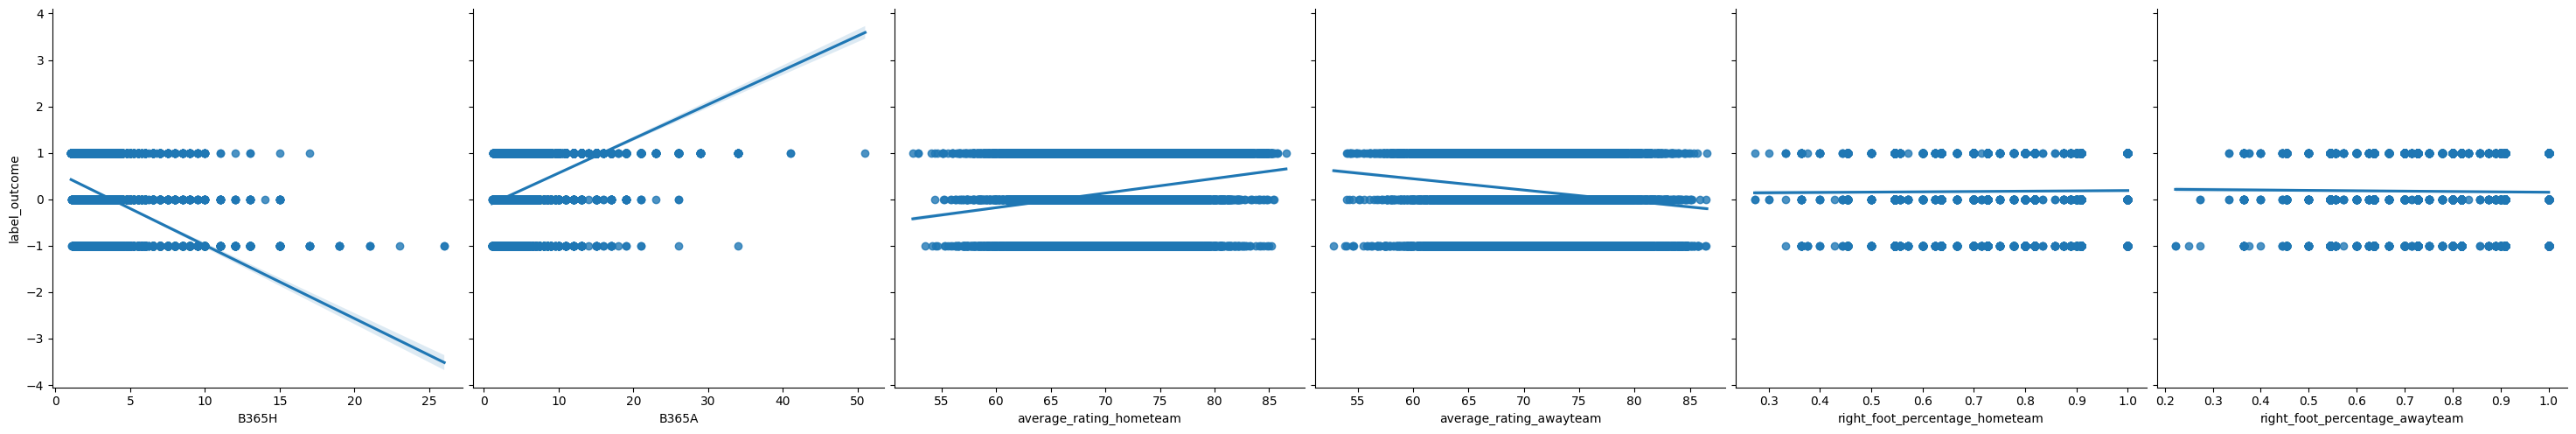

In [20]:
# Zusammenführen der ausgewählten Features und des Zielvariablenvektors in ein Pandas DataFrame
data = pd.concat([features[selected_features], target], axis=1)

# Erstellung eines Paarplots, um die Beziehungen zwischen den Variablen zu visualisieren
# x_vars: Ausgewählte Features, y_vars: Zielvariable
sns.pairplot(data, x_vars=selected_features, y_vars='label_outcome', height=5, aspect=1, kind='reg')


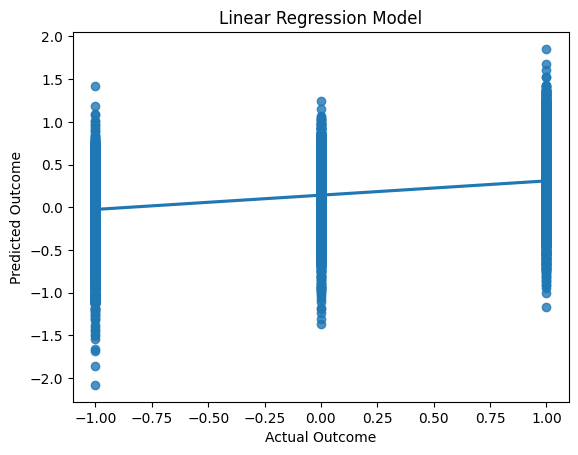

In [21]:
# Modell trainieren
model.fit(features[selected_features], target)

# Vorhersagen treffen
y_pred = model.predict(features[selected_features])

# Regressionsplot erstellen
sns.regplot(x=target, y=y_pred, ci=None)

# Achsenbeschriftungen und Titel setzen
plt.xlabel('Actual Outcome')
plt.ylabel('Predicted Outcome')
plt.title('Linear Regression Model')

# Plot anzeigen
plt.show()

# Random Forest

In [ ]:
from sklearn.impute import SimpleImputer
from random import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Entfernen von Zeilen, die NaN-Werte in der Zielvariablen enthalten
df_dropped = df.dropna(subset=['label_outcome'])

# Trennung von Features und Zielvariablen, Aussortieren von Features
features = df_dropped.drop(['match_api_id', 'date', 'season', 'id', 'country_id', 'league_id', 'home_team_api_id', 'away_team_api_id', 'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7','home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7','away_player_8', 'away_player_9', 'away_player_10', 'away_player_11', 'label_outcome', 'home_team_goal', 'away_team_goal'], axis=1)
target = df_dropped['label_outcome']

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=42)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Test-Size 0.5, Genauigkeit: {accuracy}")

estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
tree = Image(filename = 'tree.png')
display(tree)

#### Finde die besten Hyperparameter

# Definition der Hyperparameter und ihrer möglichen Werte
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'min_samples_split': randint(2,10),
              'min_samples_leaf': randint(1,10)}

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(random_state=42)

# Initialisierung des Randomized Search CV Objekts
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5,
                                 random_state=42)

# Suche nach den besten Hyperparametern auf den Trainingsdaten
rand_search.fit(features_train, target_train)

# Ausgabe der besten Hyperparameter und der Genauigkeit auf den Testdaten
print(f"Beste Hyperparameter: {rand_search.best_params_}")
print(f"Genauigkeit auf Testdaten: {rand_search.score(features_test, target_test)}")

In [ ]:
# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Test-Size 0.1, Genauigkeit: {accuracy}")

estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree01.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree01.dot', '-o', 'tree01.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
tree = Image(filename = 'tree01.png')
display(tree)

########################################################################################################

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1, random_state=42)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=300, random_state=42 ,max_depth=5)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Test-Size 0.1, Genauigkeit: {accuracy}")

estimator = rf.estimators_[0]

export_graphviz(estimator, out_file='tree02.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree02.dot', '-o', 'tree02.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
tree = Image(filename = 'tree02.png')
display(tree)

In [ ]:
# Definition der Hyperparameter und ihrer möglichen Werte
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20),
              'min_samples_split': randint(2,10),
              'min_samples_leaf': randint(1,10)}

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(random_state=42)

# Initialisierung des Randomized Search CV Objekts
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_dist,
                                 n_iter=10,
                                 cv=5,
                                 random_state=42)

# Suche nach den besten Hyperparametern auf den Trainingsdaten
rand_search.fit(features_train, target_train)

# Ausgabe der besten Hyperparameter und der Genauigkeit auf den Testdaten
print(f"Beste Hyperparameter: {rand_search.best_params_}")
print(f"Genauigkeit auf Testdaten: {rand_search.score(features_test, target_test)}")

In [ ]:
# Get the best estimator and index
best_rf = rand_search.best_estimator_
best_index = rand_search.best_index_

# Visualize the best tree
estimator = best_rf.estimators_[best_index]

export_graphviz(estimator, out_file='treebest.dot', 
                feature_names = features_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'treebest.dot', '-o', 'treebest.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
tree = Image(filename = 'treebest.png')
display(tree)

In [ ]:
# Vorhersage auf den Testdaten mit den besten Hyperparametern
best_rf = rand_search.best_estimator_
target_pred = best_rf.predict(features_test)

# Berechnung des F1-Scores
f1 = f1_score(target_test, target_pred, average='weighted')
print(f"F1-Score: {f1}")

# Berechnung der AUC
target_proba = best_rf.predict_proba(features_test)
auc = roc_auc_score(target_test, target_proba, multi_class='ovr')
print(f"AUC: {auc}")

# Berechnung der Precision
precision = precision_score(target_test, target_pred, average='weighted', zero_division=1)
print(f"Precision: {precision}")

# Berechnung des Recall
recall = recall_score(target_test, target_pred, average='weighted', zero_division=1)
print(f"Recall: {recall}")

In [ ]:
# Fit des Random Forest Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(features_train, target_train)

# Berechnung der Feature Importance
importance = best_rf.feature_importances_
sorted_idx = importance.argsort()[::-1]
print("Feature importance:")
for i in sorted_idx:
    print(f"{features_train.columns[i]}: {importance[i]}")

# Erstellung der Confusion Matrix
target_pred = rf.predict(features_test)
conf_mat = confusion_matrix(target_test, target_pred)

# Plot der Confusion Matrix
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', 
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
# Binarize the target variable
target_bin = label_binarize(target_test, classes=['Win', 'Draw', 'Lose'])
n_classes = target_bin.shape[1]

# Compute the probabilities for each class
target_proba = best_rf.predict_proba(features_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_bin[:, i], target_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(target_bin.ravel(), target_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for all classes and micro-average
plt.figure()
lw = 2
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], ['Win', 'Draw', 'Lose'][i]))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# Add some visual enhancements
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Logistische Regression

In [ ]:
#imports:
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import scale
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from scipy.stats import sem

In [ ]:
# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
#features = df_dropped.drop(["date", "match_api_id", "stage", "label_outcome", "home_team_api_id", "away_team_api_id", "home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7","home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6", "away_player_7","away_player_8", "away_player_9", "away_player_10", "away_player_11"], axis=1)
target = df_dropped['label_outcome']


In [ ]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features.columns 
  
# Errechnen des VIF für jedes Feature (Testen auf Multikollinarität -> liegt vor wenn VIF > 10)
vif_scores["VIF Scores"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))] 
display(vif_scores)

In [ ]:
#features = df_dropped.drop(["average_height_hometeam", "average_height_awayteam", "average_weight_hometeam", "average_weight_awayteam", "stage", "match_api_id", "label_outcome", "date", "home_team_api_id", "away_team_api_id", "home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7","home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6", "away_player_7","away_player_8", "away_player_9", "away_player_10", "away_player_11"], axis=1)
#features = (features-features.min())/(features.max()-features.min())


vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features.columns 
vif_scores["VIF Scores"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))] 
display(vif_scores)

In [ ]:
#features = features.drop(["average_height_hometeam", "average_height_awayteam", "average_weight_hometeam", "average_weight_awayteam"], axis=1) 
features = features.drop(["average_height_hometeam", "average_height_awayteam"], axis=1)
#features = features.drop(["B365A", "B365D", "B365H"], axis=1)

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = features.columns 
# Errechnen des VIF für jedes Feature (Testen auf Multikollinarität -> liegt vor wenn VIF > 10)
vif_scores["VIF Scores"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))] 
display(vif_scores)

In [ ]:
# wie oft jede Kategorie vertreten ist
print("Häufigkeit der einzelnen Kategorien: ")
print(target.value_counts())

# Häufigkeit der Zielvariable
sn.countplot(x = target, data = features)
plt.show()

In [ ]:
# evaluieren des Modells mit einer bestimmten Anzahl an Wiederholungen
def evaluate_model(X, y, wiederholungen, s):
 # Vorbereiten der cross-validation-Prozedur
 crossvalidation = RepeatedKFold(n_splits=s, n_repeats=wiederholungen, random_state=1)
 # Modell erstellen
 modell = LogisticRegression()
 # Modell evaluieren
 ergebnis = cross_val_score(modell, X, y, scoring='accuracy', cv=crossvalidation, n_jobs=-1)
 return ergebnis


wiederholungen = range(1,6)
ergebnisse = list()

splits = range(2,11)
for s in splits:
    for w in wiederholungen:
        scores = evaluate_model(features, target, w, s)
        print(f"Genauigkeit bei {s} Splits: {mean(scores)}")
        print('%d: Mittelwert = %.4f; Standardabweichung = %.3f' % (w, mean(scores), sem(scores)))
        ergebnisse.append(scores)
    # organgene Linie zeigt den errechneten Median der Modellgenauigkeit für  die Anzahl an Wiederholungen (Wert, bei dem 50% der Werte unter und 50% der Werte über diesem liegen)
    # grüne Dreieck zeigt das arithmetische Mittel an (den generellen Mittelwert aller Werte)
    # wo die Überschneidungen zwischen der orangenen Linie und dem gründen Dreieck vorkommen, liegt bei diesem Wert an Wiederholungen wahrscheinlich eine gute symmetrische Verteilung vor
    pyplot.boxplot(ergebnisse, labels=[str(w) for w in wiederholungen], showmeans=True)
    pyplot.show()
    ergebnisse = list()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.5, random_state=42)
mymodel = linear_model.LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
mymodel.fit(X_train, y_train)
predicted_output = mymodel.predict(X_test)
print(f"Genauigkeit: {mymodel.score(X_test, y_test)}")

spalten = X_train.columns
koeffizientenFürNiederlage = pd.Series(mymodel.coef_[0], spalten)
koeffizientenFürUnentschieden = pd.Series(mymodel.coef_[1], spalten)
koeffizientenFürSieg = pd.Series(mymodel.coef_[2], spalten)
#interceptions = mymodel.intercept_

print(f"Klasse: {mymodel.classes_}")
print("-----------------------------------------------------")
print("logarithmische Koeffizienten:")
print("-----------------------------------------------------")
print("Koeffizienten für Klasse -1:")
print(koeffizientenFürNiederlage)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 0:")
print(koeffizientenFürUnentschieden)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 1:")
print(koeffizientenFürSieg)
print("-----------------------------------------------------")
#print(f"Interceptions: {interceptions}")
#print("-----------------------------------------------------")

#logarithmische zu regulären Werten umrechnen
koeffizientenFürNiederlageRegulaer = pd.Series(np.exp(mymodel.coef_[0]), spalten)
koeffizientenFürUnentschiedenRegulaer = pd.Series(np.exp(mymodel.coef_[1]), spalten)
koeffizientenFürSiegRegulaer = pd.Series(np.exp(mymodel.coef_[2]), spalten)
#interceptionsRegulaer = np.exp(mymodel.intercept_)


print("-----------------------------------------------------")
print("reguläre Koeffizienten:")
print("-----------------------------------------------------")
print("Koeffizienten für Klasse -1:")
print(koeffizientenFürNiederlageRegulaer)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 0:")
print(koeffizientenFürUnentschiedenRegulaer)
print("-----------------------------------------------------")
print("Koeffizienten für Klasse 1:")
print(koeffizientenFürSiegRegulaer)
print("-----------------------------------------------------")
#print(f"Interceptions: {interceptionsRegulaer}")
#print("-----------------------------------------------------")


#logarithmische Wahrscheinlichkeit, dass mithilfe dieses Features das Spielergebnis vorhergesagt werden kann
plt.figure(figsize= (8,10))
koeffizientenFürNiederlage.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("logarithmische Wahrscheinlichkeit, dass ein Feature das Spielergebnis vorhersagen kann")
plt.show()

plt.figure(figsize= (8,10))
koeffizientenFürUnentschieden.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("logarithmische Wahrscheinlichkeit, dass ein Feature das Spielergebnis vorhersagen kann")
plt.show()

plt.figure(figsize= (8,10))
koeffizientenFürSieg.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("logarithmische Wahrscheinlichkeit, dass ein Feature das Spielergebnis vorhersagen kann")
plt.show()

plt.figure(figsize= (8,10))
koeffizientenFürNiederlageRegulaer.sort_values().plot.barh()
plt.ylabel("Feature")
plt.xlabel("Wahrscheinlichkeit, dass ein Feature das Spielergebnis vorhersagen kann")
plt.show()


cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mymodel, features, target, scoring="accuracy", cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


# wie die regulären Werte zu interpretieren sind: 

# Wenn man bei der Klasse Niederlage einen regulären Koeffizienten von 1,046 hat und nun vom Overall_Rating 1 abzieht, 
# dann steigt die Wahrscheinlichkeit, dass das Team verliert um 4,6%

# Wenn man bei der Klasse Niederlage einen regulären Koeffizienten von 0,964 hat und vom Overall_Rating 1 abzieht,
# dann sinkt die Wahrscheinlichkeit, dass das Team verliert um 4,6%



# Odds Ratio (die regulären Koeffizienten) geben an, um wie viel größer die Chance auf das Ergebnis (-1, 0 oder 1) ist, bei einer Stufe höher auf der 
# Prädiktor-Variable (Wenn das Heimteam zum Beispiel ein Tor schießt)
# Wert von 1 -> gleiches Chancenverhältnis
# Wert von unter 1 -> Chancenverhältnis nimmt ab
# Wert von über 1 -> Chancenverhältnis nimmt zu



"""
sn.countplot(x = y_train, data = features)
plt.show()
sn.countplot(x = y_test, data = features)
plt.show()
"""

#multiklassen-Klassifizierung notwendig, da wir nicht nur Sieg und Niederlage haben, sondern auch noch Unentschieden
# 1. Aufteilen der Daten in Training- und Testdaten

testSize = range(2,9)
for t in testSize:
    print(f"Genauigkeit bei einer Testgröße von {t/10}:")
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=(t/10), random_state=42)

    mymodel = linear_model.LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=3000)
    mymodel.fit(X_train, y_train)

    predicted_output = mymodel.predict(X_test)
    #print(f"Genauigkeit: {mymodel.score(X_test, y_test)}")
    print(f"Genauigkeit: {mymodel.score(X_test, y_test)}")

    cm = confusion_matrix(y_test, predicted_output)
    mse = mean_squared_error(y_test, predicted_output)
    r2 = r2_score(y_test, predicted_output)
    print(f"mean squared error: {mse}")
    print(f"r2 score (Wie viel Prozent der Varianz werden erklärt?): {r2}")
 
    plt.figure(figsize= (6,6))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Vorhergesagter Wert')
    plt.ylabel('tatsächlicher Wert')
    plt.show()


In [ ]:
# Auswirkung von home_team_rating auf away_team_goal
#x = features['average_rating_hometeam']
#y = features['away_team_goal']

#plt.scatter(x, y)  
#plt.plot(np.unique(x),np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'green')  
#print("Auswirkungen des average_rating_hometeam auf die Anzahl an Gegentoren (Aus Sicht des Heimteams):")
#plt.xlabel("Rating des Heimteams")
#plt.ylabel("Anzahl an Gegentoren (aus Sicht des Heimteams)")
#plt.show()

# Auswirkung von home_team_rating auf label_outcome
x = features['average_rating_hometeam']
y = target

plt.scatter(x, y)  
plt.plot(np.unique(x),np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'green')  
print("Auswirkungen des average_rating_hometeam auf den Spielausgang (Aus Sicht des Heimteams):")
plt.xlabel("Rating des Heimteams")
plt.ylabel("Spielausgang (aus Sicht des Heimteams)")
plt.show()

# Auswirkung von away_team_rating auf label_outcome
x = features['average_rating_awayteam']
y = target

plt.scatter(x, y)  
plt.plot(np.unique(x),np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = 'green')  
print("Auswirkungen des average_rating_awayteam auf den Spielausgang (Aus Sicht des Heimteams):")
plt.xlabel("Rating des Auswärtsteams")
plt.ylabel("Spielausgang (aus Sicht des Heimteams)")
plt.show()